# Data Exploration in Splice Machine
<blockquote><p class='quotation'><span style='font-size:15px'> Data exploration couldn't be easier on Splice. Our built in, scalable Spark Sessions allow you to run massive analytics, and our robust library support removes the learning curve. In this notebook, we'll ingest our SQL table into a Spark Dataframe using the Native Spark Datasource, and then use <code>Koalas</code> to give us Pandas API syntax on distributed Spark Dataframes! <a href=https://koalas.readthedocs.io/en/latest/getting_started/index.html>Koalas</a> is a powerful library and removes the need to learn PySpark syntax to run large scale analytics on your data.<br>

In order to use Koalas (or any other custom library you'd like), simply <code>pip install</code> right in a notebook. If importing koalas fails after the install, you may need to restart the kernel after installing:
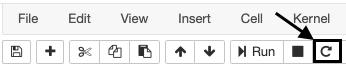

Then, simply import the library and you're ready to go!<br><br>
Note: If you've already installed Koalas in another notebook (or in a terminal session), you won't need to reinstall it.
<footer>Splice Machine</footer>


In [ ]:
!pip install -q koalas

#### Let's start our Spark Session

In [ ]:
# Setup
import warnings
warnings.simplefilter("ignore")
warnings.filterwarnings("ignore")

import databricks.koalas as ks
from pyspark.sql import SparkSession
from splicemachine.spark import PySpliceContext
from splicemachine.mlflow_support.utilities import get_user

spark = SparkSession.builder.getOrCreate()
splice = PySpliceContext(spark)
schema = get_user()

## Ingesting Data
<blockquote><p class='quotation'><span style='font-size:15px'> There are a variety of ways to ingest data into Splice Machine. here we'll use the built in <code>IMPORT_DATA</code> SQL function to bring data from s3 directly into a Splice Machine table. From there we'll be able to investigate our features. <footer>Splice Machine</footer>
</blockquote>

In [ ]:
%%sql
drop table if exists cc_fraud_data; 
create table cc_fraud_data (
    time_offset integer,
    expected_weekly_trans_cnt double,
    expected_weekly_trans_amnt double,
    expected_daily_trans_cnt double,
    expected_daily_trans_amnt double,
    weekly_trans_cnt double,
    weekly_trans_amnt double,
    daily_trans_cnt double,
    daily_trans_amnt double,
    rolling_avg_weekly_trans_cnt double,
    rolling_avg_weekly_trans_amnt double,
    rolling_avg_daily_trans_cnt double,
    rolling_avg_daily_trans_amnt double,
    MACD_trans_amnt double,
    MACD_trans_cnt double,
    RSI_trans_amnt double,
    RSI_trans_cnt double,
    Aroon_trans_amnt double,
    Aroon_trans_cnt double,
    ADX_trans_amnt double,
    ADX_trans_cnt double,
    current_balance double,
    rolling_avg_balance double,
    MACD_balance double,
    Aroon_balance double,
    RSI_balance double,
    ADX_balance double,
    credit_score double,
    credit_limit double,
    amount decimal(10,2),
    class_result int
);

call SYSCS_UTIL.IMPORT_DATA (
     null,
     'cc_fraud_data',
     null,
     's3a://splice-demo/kaggle-fraud-data/creditcard.csv',
     ',',
     null,
     null,
     null,
     null,
     -1,
     's3a://splice-demo/kaggle-fraud-data/bad',
     null, 
     null);
     

## We can use `SQL` natively to investigate our data

In [ ]:
%%sql
-- Get the class distribution of our label
select class_result, count(*) as NUM_Occurrences
from cc_fraud_data 
group by class_result

In [ ]:
%%sql 
-- Calculate averages for some important metrics
SELECT class_result, AVG(expected_weekly_trans_cnt) as avg_expected_weekly_trans_cnt, 
AVG(MACD_trans_amnt) as avg_MACD_trans_amnt, 
AVG(RSI_trans_amnt) as avg_RSI_trans_amnt
from cc_fraud_data
group by class_result

## Using the Native Spark Data Source (and Koalas) to get our data in PySpark

In [ ]:
df = splice.df(f"SELECT * FROM {schema}.cc_fraud_data").to_koalas().astype({'AMOUNT': 'float64'})
print(type(df))

#### With Koalas, your dataframe looks and feels like a Pandas DF

In [ ]:
df

## Let's use Koalas
<blockquote><p class='quotation'><span style='font-size:15px'> Now that we have our Koalas dataframe, we can use standard Pandas API, but distribute it all on Spark. Let's try some standard functions, and inspect what Koalas is doing under the hood <footer>Splice Machine</footer>
</blockquote>

In [ ]:
# Sort by amount spent in transaction, looking at Amount, Current balance, and Weekly Transaction count
df.sort_values(by='AMOUNT', ascending=False)[['AMOUNT','CURRENT_BALANCE', 'WEEKLY_TRANS_CNT']]

In [ ]:
# See rows with WEEKLY_TRANS_AMNT above 25
df[df['WEEKLY_TRANS_AMNT'] > 18]

#### See what's happening under the hood

In [ ]:
# See what Koalas is doing under the hood
df[df['WEEKLY_TRANS_AMNT'] > 18].spark.explain()

## Great! Let's do some investigation
<blockquote><p class='quotation'><span style='font-size:15px'>Now that we see the power of Koalas, let's use it! We'll look at some feature correlations and distributions without having to sample our data.<footer>Splice Machine</footer>
</blockquote>

## Investigating if there is any correlation among our features

### If there is, we need to remove the correlated ones.

#### Let's try this with Pandas... We'll need to take a sample of data in memory

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pyspark.sql.types import FloatType, IntegerType

%matplotlib inline

sdf = df.to_spark()
pdf = sdf.where(sdf['CLASS_RESULT']==1).toPandas().append(sdf.limit(1000).toPandas())
corr = pdf.corr()

ticks = [i for i in range(len(corr.columns))]
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Color Scheme
cmap = "coolwarm"

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.xticks(ticks, corr.columns)
plt.yticks(ticks, corr.columns)
plt.title('Fraud Data correlation heatmap')
plt.show()

## It seems like there's a lot of correlation among features! 

<blockquote><p class='quotation'><span style='font-size:15px'>We see a lot of correlation here, which would mean we need to remove some features. But this may be because we are taking a sample of our true dataset. Let's try the same code with Koalas and get a view of the full population data.<footer>Splice Machine</footer>
</blockquote>

#### With Koalas...

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline

corr = df.corr() # This is a koalas dataframe 
corr_pdf = corr.to_pandas() # Doing this so we can easily use the seaborn heatmap functionality

ticks = [i for i in range(len(corr_pdf.columns))]
mask = np.triu(np.ones_like(corr_pdf, dtype=np.bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = "coolwarm"

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_pdf, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.xticks(ticks, corr_pdf.columns)
plt.yticks(ticks, corr_pdf.columns)
plt.title('Credit Card Fraud Data Feature Correlation Heatmap')
plt.show()

## Wow!

<blockquote><p class='quotation'><span style='font-size:15px'>That's a serious difference. It turns out there isn't any correlation here. Had we stuck with Pandas we would have introduced bias into our system.<footer>Splice Machine</footer>
</blockquote>

## Investigating the distribution of our features

In [ ]:
features = list(df.columns)
features.remove("CLASS_RESULT")

In [ ]:
# Understanding our features in terms of their spread
df[features].describe()

### Visualizing our features distributions

#### Note: This will create a lot of spark jobs! This may slow down the UI. You can minimize the monitor below by clicking the little arrow on the top left of the orange Spark Jobs bar below the cell.
<img src=https://splice-demo.s3.amazonaws.com/Spark+Monitor+Minimize.png></img>

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('seaborn')

fig, axes = plt.subplots(nrows=5, ncols=6, figsize=(30,10))
for i,f in enumerate(features):
    row = i%5
    col = i//5
    axes[row,col] = df[f].plot.hist(bins=50, alpha=0.5,normed = True, ax = axes[row,col])
    axes[row,col].set_xlabel(f)
    axes[row,col].set_xticks([])
    axes[row,col].set_yticks([round(t,7) for t in axes[row,col].get_yticks()])

## Investigating our features correlation to our target

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))

most_correlated = corr.abs()['CLASS_RESULT'].sort_values(ascending=False).reset_index()
most_correlated = most_correlated.iloc[1:].rename({"index":"feature","CLASS_RESULT":"correlation_to_target"}, axis = 1)
ax = most_correlated.plot.bar(x = "feature",y = "correlation_to_target", ax = ax, legend = None)
ax.set_ylabel("Correlation to Target") 
ax.set_title("Feature Correlation to Target Variable")


# Fantastic!
<blockquote> 
We've just demonstrated our platform's ability to execute simple feature investigation routines <br>
    Next Up: <a href='./7.4 Feature Engineering.ipynb'>Using MLManager to Engineer Features</a>
<footer>Splice Machine</footer>
</blockquote>

In [ ]:
spark.stop()